# Basé sur analysis_3d version 0.14, mais cette fois ci avec Sagittarius A* comme objet étudié.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.data import DataStore
from gammapy.irf import EnergyDispersion, make_mean_psf, make_mean_edisp
from gammapy.maps import WcsGeom, MapAxis, Map, WcsNDMap
from gammapy.cube import MapMaker, PSFKernel, MapDataset
from gammapy.modeling.models import (
    SkyModel,
    SkyDiffuseCube,
    BackgroundModel,
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
)
from gammapy.spectrum import FluxPointsEstimator
from gammapy.modeling import Fit

In [3]:
# Define which data to use and print some information
data_store = DataStore.from_dir("$HESS_DATA/ash_stereo_Prod17_Calib0834_thsq64")
data_store.info()

Data store:
HDU index table:
BASE_DIR: /Users/user/hess/data/ash_stereo_Prod17_Calib0834_thsq64
Rows: 122853
OBS_ID: 18092 -- 151486
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_2d', 'edisp_2d', 'events', 'gti', 'psf_3gauss', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 20485



In [4]:
print(
    "Observation time (hours): ", data_store.obs_table["ONTIME"].sum() / 3600
)
print("Observation table: ", data_store.obs_table.colnames)
print("HDU table: ", data_store.hdu_table.colnames)

Observation time (hours):  9266.447777777777
Observation table:  ['AIRTEMP', 'ALT_PNT', 'AZ_PNT', 'BKG_SCALE', 'BROKPIX', 'DATE_END', 'DATE_OBS', 'DEADC', 'DEC_OBJ', 'DEC_PNT', 'EFFAREA_MAX', 'EFFAREA_RECO_MAX', 'EVENT_COUNT', 'EVENT_DEC_MEDIAN', 'EVENT_ENERGY_MEDIAN', 'EVENT_RA_MEDIAN', 'EVENT_TIME_MAX', 'EVENT_TIME_MIN', 'GLAT_PNT', 'GLON_PNT', 'HI_THRES', 'LIVETIME', 'LO_THRES', 'MUONEFF', 'NSBLEVEL', 'N_TELS', 'OBJECT', 'OBS_ID', 'ONTIME', 'PRESSURE', 'QUALITY', 'RA_OBJ', 'RA_PNT', 'RELHUM', 'TELLIST', 'TIME_END', 'TIME_OBS', 'TMID', 'TMID_STR', 'TRGRATE', 'TSTART', 'TSTART_STR', 'TSTOP', 'TSTOP_STR', 'ZEN_PNT', 'ZTRGRATE']
HDU table:  ['OBS_ID', 'HDU_TYPE', 'HDU_CLASS', 'FILE_DIR', 'FILE_NAME', 'HDU_NAME', 'SIZE', 'MTIME', 'MD5']


In [5]:
#data_store.obs_table["OBS_ID",'GLAT_PNT', 'GLON_PNT', 'OBJECT'][190:210]

In [6]:
# une formule simple pour lire l'objet observé lors d'une observation donnée
data_store.obs(20549).obs_info['OBJECT']

'Sgr A*'

In [7]:
%%time
ids = list(data_store.obs_table['OBS_ID'])
ids_gc = []

for k in ids :
    if data_store.obs(k).obs_info['OBJECT'] == 'Sgr A*':
        ids_gc.append(k)

print(ids_gc)

[20549, 20550, 20551, 20552, 20553, 20554, 20567, 20568, 20572, 20573, 20580, 20581, 20582, 20583, 20584, 20596, 20597, 20598, 20608, 20609, 20922, 20923, 20924, 20925, 20929, 20930, 20967, 20968, 20998, 20999, 21006, 21007, 21016, 21017, 21027, 21028, 21146, 21147, 21148, 21149, 21165, 21166, 21167, 21168, 21245, 21275, 21276, 21347, 21348, 21349, 21350, 21372, 21373, 21376, 21377, 21389, 21390, 21411, 21452, 21453, 21463, 21464, 21486, 21491, 21492, 21493, 21494, 21496, 21497, 21508, 21862, 21863, 21872, 21873, 21874, 21876, 21877, 21894, 21895, 21896, 21897, 21909, 21910, 22258, 25330, 25331, 25349, 25350, 25353, 25379, 25380, 25401, 25402, 25403, 25404, 25405, 25709, 26078, 26079, 26080, 26081, 26082, 26083, 26084, 26085, 26086, 26087, 26088, 26089, 26090, 26091, 26104, 26105, 26106, 26107, 26108, 26109, 26110, 26111, 26112, 26113, 26114, 26115, 26116, 26789, 26790, 26810, 26811, 26812, 26813, 27375, 27376, 27377, 27378, 27498, 27499, 27500, 27501, 27502, 27503, 27504, 27505, 27506

In [92]:
from astropy.coordinates import Angle

selection = dict(type='sky_circle', frame='galactic',
                 lon=Angle(0, 'deg'),
                 lat=Angle(0, 'deg'),
                 radius=Angle(5, 'deg'),
                 border=Angle(2, 'deg'))
selected_obs_table = data_store.obs_table.select_observations(selection)

In [97]:
obs_ids = list(selected_obs_table["OBS_ID"])
obs_ids[0]

20191

In [98]:
observations = data_store.get_observations(obs_ids)

In [99]:
energy_axis = MapAxis.from_edges(
    np.logspace(-1.0, 2.0,20), unit="TeV", name="energy", interp="log")

geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

In [100]:
%%time
maker = MapMaker(geom, offset_max=4.0 * u.deg)
maps = maker.run(observations)

IndexError: No HDU found matching: OBS_ID = 31539, HDU_TYPE = aeff, HDU_CLASS = None

In [101]:
path = Path("analysis_3d_gc")
path.mkdir(exist_ok=True)

# write maps
maps["counts"].write(str(path / "countsGCtot.fits"), overwrite=True)
maps["background"].write(str(path / "backgroundGCtot.fits"), overwrite=True)
maps["exposure"].write(str(path / "exposureGCtot.fits"), overwrite=True)

In [106]:
data_store.obs(31539).obs_info

{'AIRTEMP': <Quantity 11.66925 degC>,
 'ALT_PNT': <Quantity 90. deg>,
 'AZ_PNT': <Quantity 180. deg>,
 'BKG_SCALE': -1.0,
 'BROKPIX': 0.008072916,
 'DATE_END': '2006-04-29',
 'DATE_OBS': '2006-04-29',
 'DEADC': 0.9079595,
 'DEC_OBJ': <Quantity -27.925661 deg>,
 'DEC_PNT': <Quantity -27.925661 deg>,
 'EFFAREA_MAX': -1.0,
 'EFFAREA_RECO_MAX': -1.0,
 'EVENT_COUNT': 3046,
 'EVENT_DEC_MEDIAN': <Quantity -27.99126 deg>,
 'EVENT_ENERGY_MEDIAN': <Quantity 0.38741922 TeV>,
 'EVENT_RA_MEDIAN': <Quantity 267.87665 deg>,
 'EVENT_TIME_MAX': <Quantity 1.67974445e+08 s>,
 'EVENT_TIME_MIN': <Quantity 1.67972759e+08 s>,
 'GLAT_PNT': <Quantity -0.6997388 deg>,
 'GLON_PNT': <Quantity 1.5998287 deg>,
 'HI_THRES': -1,
 'LIVETIME': <Quantity 1526.2799 s>,
 'LO_THRES': -1,
 'MUONEFF': 0.65771043,
 'NSBLEVEL': -1000000.0,
 'N_TELS': 4,
 'OBJECT': 'G1.6-0.7',
 'OBS_ID': 31539,
 'ONTIME': <Quantity 1681. s>,
 'PRESSURE': <Quantity 823.0008 hPa>,
 'QUALITY': -1,
 'RA_OBJ': <Quantity 268.02438 deg>,
 'RA_PNT': <Q

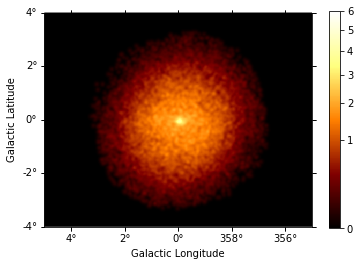

In [107]:
counts = maps["counts"].sum_over_axes()
counts.smooth(width=0.05 * u.deg).plot(stretch="sqrt", add_cbar=True, vmax=6);

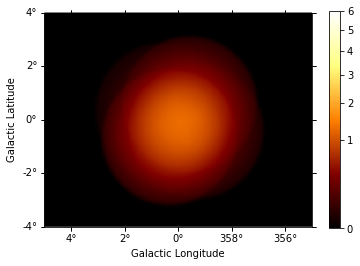

In [108]:
background = maps["background"].sum_over_axes()
background.smooth(width=0.05 * u.deg).plot(
    stretch="sqrt", add_cbar=True, vmax=6
);

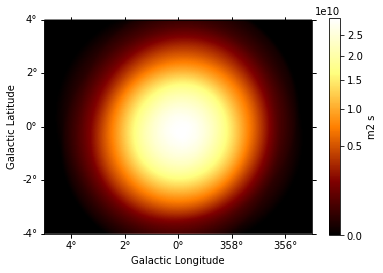

In [109]:
exposure = maps["exposure"].sum_over_axes()
exposure.smooth(width=0.05 * u.deg).plot(stretch="sqrt", add_cbar=True);

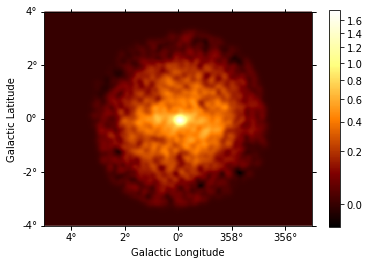

In [110]:
excess = counts - background
excess.smooth(5).plot(stretch="sqrt", add_cbar=True);

Les IRF

In [111]:
# mean PSF
src_pos = SkyCoord(0.1, 0.1, unit="deg", frame="galactic")
table_psf = make_mean_psf(observations, src_pos)

# PSF kernel used for the model convolution
psf_kernel = PSFKernel.from_table_psf(table_psf, geom, max_radius="0.4 deg")

Found multiple HDU matching: OBS_ID = 20191, HDU_TYPE = psf, HDU_CLASS = None. Returning the first entry, which has HDU_TYPE = psf and HDU_CLASS = psf_3gauss


KeyError: "Key 'SIGMA_1' does not exist."

PSF does not integrate to unity within a precision of 1% in each energy bin. Containment radius computation might give biased results.
PSF does not integrate to unity within a precision of 1% in each energy bin. Containment radius computation might give biased results.
PSF does not integrate to unity within a precision of 1% in each energy bin. Containment radius computation might give biased results.


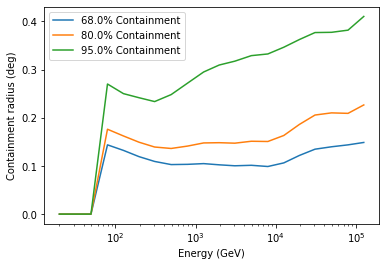

In [67]:
table_psf.plot_containment_vs_energy()

In [69]:
# define energy grid
energy = energy_axis.edges

# mean edisp
edisp = make_mean_edisp(
    observations, position=src_pos, e_true=energy, e_reco=energy
)

In [20]:
path = Path("analysis_3d_gc")
path.mkdir(exist_ok=True)

In [70]:
# write maps
maps["counts"].write(str(path / "counts.fits"), overwrite=True)
maps["background"].write(str(path / "background.fits"), overwrite=True)
maps["exposure"].write(str(path / "exposure.fits"), overwrite=True)

# write IRFs
psf_kernel.write(str(path / "psf.fits"), overwrite=True)
edisp.write(str(path / "edisp.fits"), overwrite=True)

In [71]:
# read maps
maps = {
    "counts": Map.read(str(path / "counts.fits")),
    "background": Map.read(str(path / "background.fits")),
    "exposure": Map.read(str(path / "exposure.fits")),
}

# read IRFs
psf_kernel = PSFKernel.read(str(path / "psf.fits"))
edisp = EnergyDispersion.read(str(path / "edisp.fits"))

In [72]:
coords = maps["counts"].geom.get_coord()
mask = coords["energy"] > 0.3 * u.TeV

In [73]:
spatial_model = PointSpatialModel(
    lon_0="0.1 deg", lat_0="0.1 deg", frame="galactic"
)

spatial_model.parameters["lon_0"]
spectral_model = PowerLawSpectralModel(
    index=2.2, amplitude="3e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model,
    name="gc-source")

In [74]:
background_model = BackgroundModel(maps["background"], norm=1.1, tilt=0.0)
background_model.parameters["norm"].frozen = False
background_model.parameters["tilt"].frozen = True

In [75]:
dataset = MapDataset(
    model=model,
    counts=maps["counts"],
    exposure=maps["exposure"],
    background_model=background_model,
    mask_fit=mask,
    psf=psf_kernel,
    edisp=edisp,
)

In [77]:
%%time
fit = Fit(dataset)
result = fit.run(optimize_opts={"print_level": 1})

RuntimeError: exception was raised in user function
User function arguments:
        par_000_lon_0 = +8.413948
        par_001_lat_0 = +4.982591
        par_002_index = +2.256992
    par_003_amplitude = -2.319803
         par_004_norm = +1.214830
Original python exception in user function:
ValueError: Position <SkyCoord (Galactic): (l, b) in deg
    (0.08413948, 4.98259111)> of model component is outside the image boundaries. Please check the starting values or position parameter boundaries of the model.
  File "/Users/user/anaconda3/envs/gammapy-0.14/lib/python3.7/site-packages/gammapy/modeling/iminuit.py", line 17, in fcn
    return self.function()
  File "/Users/user/anaconda3/envs/gammapy-0.14/lib/python3.7/site-packages/gammapy/modeling/datasets.py", line 132, in likelihood
    total_likelihood += dataset.likelihood()
  File "/Users/user/anaconda3/envs/gammapy-0.14/lib/python3.7/site-packages/gammapy/cube/fit.py", line 515, in likelihood
    counts, npred = self._counts_data, self.npred().data
  File "/Users/user/anaconda3/envs/gammapy-0.14/lib/python3.7/site-packages/gammapy/cube/fit.py", line 275, in npred
    evaluator.update(self.exposure, self.psf, self.edisp, self._geom)
  File "/Users/user/anaconda3/envs/gammapy-0.14/lib/python3.7/site-packages/gammapy/cube/fit.py", line 851, in update
    f"Position {self.model.position!r} of model component is outside the image boundaries."


In [40]:
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 244
	total stat : 206984.93



In [41]:
result.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,-5.682e-02,6.144e-03,deg,nan,nan,False
lat_0,-5.935e-02,6.081e-03,deg,-9.000e+01,9.000e+01,False
index,2.454e+00,1.343e-01,,nan,nan,False
amplitude,2.128e-12,2.455e-13,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
norm,1.207e+00,6.610e-03,,0.000e+00,nan,False
tilt,0.000e+00,0.000e+00,,nan,nan,True
reference,1.000e+00,0.000e+00,TeV,nan,nan,True


In [42]:
npred = dataset.npred()

In [43]:
residual = maps["counts"] - npred

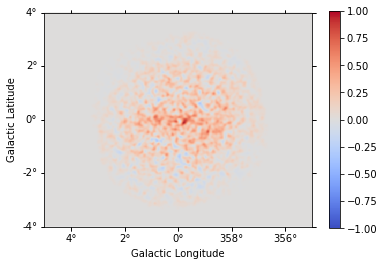

In [44]:
residual.sum_over_axes().smooth(width=0.05 * u.deg).plot(
    cmap="coolwarm", vmin=-1, vmax=1, add_cbar=True
);

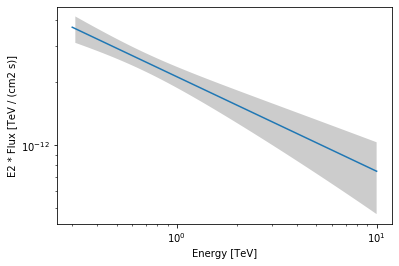

In [45]:
spec = model.spectral_model

# set covariance on the spectral model
covariance = result.parameters.covariance
spec.parameters.covariance = covariance[2:5, 2:5]

energy_range = [0.3, 10] * u.TeV
spec.plot(energy_range=energy_range, energy_power=2)
spec.plot_error(energy_range=energy_range, energy_power=2)

In [87]:
# Calculating flux points

e_edges = np.logspace(0, 2, 10) * u.TeV
fpe = FluxPointsEstimator(
    datasets=[dataset], e_edges=e_edges, source="gc-source"
)

In [88]:
%%time
flux_points = fpe.run()

Fit failed for flux point between 0.774 TeV and 1.292 TeV, setting NaN.


CPU times: user 10.7 s, sys: 2.59 s, total: 13.3 s
Wall time: 13.3 s


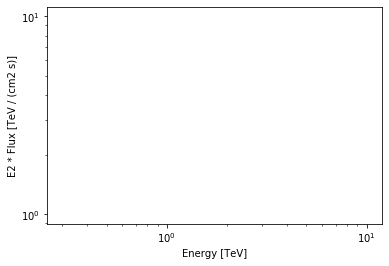

In [89]:
flux_points.table["is_ul"] = flux_points.table["ts"] < 4
ax = flux_points.plot(energy_power=2)
model.spectral_model.plot(
    ax=ax, energy_range=energy_range, energy_power=2
);

In [57]:
np.logspace(-0.5, 1, 20)

array([ 0.31622777,  0.37926902,  0.45487779,  0.54555948,  0.65431891,
        0.78475997,  0.94120497,  1.12883789,  1.35387618,  1.62377674,
        1.94748304,  2.33572147,  2.80135676,  3.35981829,  4.02961132,
        4.83293024,  5.79639395,  6.95192796,  8.33782223, 10.        ])